In [23]:
import pandas as pd
import numpy as np


In [121]:
# what is the plan?
# we make 3 different types of analyses
# in order to do this we have to first import the databases

# here we write a function to grab all the files from a directory
import os
import re

test_path = "../data/Adam Henrique_C1_gamelogs.csv"

def getFilepaths(path):
    "Returns a list of all filepaths discovered by the system in a specified folder"
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# then we write a function that takes one file and extracts the data we're interested in (shooting percentage, shots taken, position, name)
def extractShootingData(file):
    name_pattern = r'^[^_]+'
    position_pattern = r'[LW|RW|C|D|F][0-9]+_'

    name = re.findall(name_pattern, file)
    name = name[0][8:] # cut off the earlier part
    position = re.findall(position_pattern, file)
    #print(position)
    try:
        position = position[0][:-2] # cut off last two letters
    except:
        print(name, position, "Error encountered here")

    gamelogs = pd.read_csv(file)
    #print(gamelogs)
    # recover all usable data
    data = gamelogs.loc[gamelogs["shots"]>0, ["date", "shots", "shot_pct"]]

    #print(name, position)
    #print(data)
    return {"name":name, "position":position, "data":data}

player_dict = extractShootingData(test_path)
print(player_dict)




{'name': 'Adam Henrique', 'position': 'C', 'data':            date  shots  shot_pct
0    2011-04-10      3       0.0
2    2011-10-10      1       0.0
3    2011-10-22      1       0.0
4    2011-10-25      2       0.0
5    2011-10-27      4       0.0
..          ...    ...       ...
905  2024-04-06      2       0.0
907  2024-04-12      4      25.0
909  2024-04-15      3      33.3
910  2024-04-17      1       0.0
911  2024-04-18      2       0.0

[764 rows x 3 columns]}


In [68]:
# In this cell we do the most basic form of analysis

# Ex. suppose we assume 90% correlation between seasons, this means we need to find a discount such that
# discount ** 80 = .9

def find_discount_factor(desired_season_correlation=.9):
    """ This function finds the discount factor game to game to get a desired correlation per season."""
    return desired_season_correlation**(1/80)

# We take each shot as an observation/sample, and we update on an ongoing basis
# We also include a discounted version in here since most of the code is the same, we just keep the discount factor at 1 by default if its unspecified
def simple_analysis(game_information: pd.DataFrame, season_correlation=1):

    def recover_successes(row):
        return int(row.shots * row.shot_pct/100)
    
    discount = find_discount_factor(season_correlation)
    #print(game_information)
    total_shots = 0
    total_goals = 0

    cumulative_mean = []
    cumulative_sd = []
    for row in game_information.itertuples():
        goals = recover_successes(row)
        total_goals = total_goals*discount + goals
        total_shots = total_shots*discount + row.shots
        cumulative_mean.append(total_goals/total_shots)
        cumulative_sd.append((cumulative_mean[-1] * (1-cumulative_mean[-1]) / total_shots)**(1/2))

    game_information["cumulative_mean"] = np.array(cumulative_mean)
    game_information["cumulative_std"] = np.array(cumulative_sd)
    

    #print(game_information)
    return game_information


player_dict = extractShootingData(test_path)
undiscounted_simple = simple_analysis(player_dict["data"])
player_dict = extractShootingData(test_path)
discounted_simple = simple_analysis(player_dict["data"], season_correlation=.9)


In [112]:
# in this cell we will use matplotlib to display the career of a player and its confidence intervals
import matplotlib.pyplot as plt
import mplcursors

def plot_with_confidence_interval(x, mean_values, std_devs, confidence=1.96, alpha=0.3, figsize=(10,6)):
    """
    Plots a line graph with semi-transparent confidence intervals.
    
    Parameters:
    - x: array-like, the x values.
    - mean_values: array-like, the mean values for each x.
    - std_devs: array-like, the standard deviations for each x.
    - confidence: float, the z-score for the desired confidence level (default is 1.96 for 95% confidence interval).
    - alpha: float, transparency level of the confidence interval (default is 0.3).
    """
    
    # Calculate the confidence interval
    lower_bound = mean_values - confidence * std_devs
    upper_bound = mean_values + confidence * std_devs
    
    # Plot the mean values
    plt.plot(x, mean_values, label='Mean Values', color='blue')
    
    # Fill between the confidence intervals
    plt.fill_between(x, lower_bound, upper_bound, color='blue', alpha=alpha, label=f'{int(confidence*100/2)}% Confidence Interval')
    
    # Adding labels and title
    plt.xlabel('X Values')
    plt.ylabel('Mean Values')
    plt.title('Line Graph with Confidence Interval')
    plt.legend()
    
    # Show the plot
    plt.show()

# Standard usage
'''
mean_values = result_of_simple_analysis["cumulative_mean"]
sd_values = result_of_simple_analysis["cumulative_sd"]
x_vals = [i+1 for i in range(len(mean_values))]
plot_with_confidence_interval(x=x_vals, mean_values=mean_values, std_devs=sd_values)
'''
def plot_multiple_with_confidence_intervals(mean_series, std_dev_series, labels=None, confidence=1.96, alpha=0.2, CHOP=100, figsize=(10,6)):
    """
    Plots multiple lines with semi-transparent confidence intervals.
    
    Parameters:
    - mean_series: list of array-like, the mean values for each series.
    - std_dev_series: list of array-like, the standard deviations for each series.
    - labels: list of strings, the labels for each series (default is None).
    - confidence: float, the z-score for the desired confidence level (default is 1.96 for 95% confidence interval).
    - alpha: float, transparency level of the confidence interval (default is 0.3).
    - figsize: tuple, size of the figure (width, height) (default is (10, 6)).
    """
    
    # Check that the number of mean_series and std_dev_series match
    if len(mean_series) != len(std_dev_series):
        raise ValueError("mean_series and std_dev_series must have the same length.")
    
    # Determine the longest series length
    max_length = max(len(series) for series in mean_series)
    

    # Create a new plot with figure figsize
    plt.figure(figsize=figsize)

    # Keep track of all lines to be able to connect mplcursors
    lines = []


    # Plot each series with its confidence interval
    for i in range(len(mean_series)):
        series_length = len(mean_series[i])
        x = [CHOP+i for i in range(series_length)]
        mean_values = mean_series[i]
        std_devs = std_dev_series[i]
        label = labels[i] if labels else f'Series {i+1}'

        #print(mean_values)
        
        # Calculate the confidence interval
        lower_bound = mean_values - confidence * std_devs
        upper_bound = mean_values + confidence * std_devs
        
        # Plot the mean values
        lines.append(plt.plot(x, mean_values, label=label))
        
        # Fill between the confidence intervals
        plt.fill_between(x, lower_bound, upper_bound, alpha=alpha)
    
    # Adding labels and title
    plt.xlabel('X Values')
    plt.ylabel('Mean Values')
    plt.title('Multiple Line Graphs with Confidence Intervals')
    # Move legend to the right of the plot
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Adjust the plot to make space for the legend
    #plt.tight_layout(rect=[0, 0, 0.75, 1])
    
        # Use mplcursors to interact with the legend
    cursor = mplcursors.cursor(legend)
    
    # Highlight the line and confidence interval on hover
    @cursor.connect("add")
    def on_hover(sel):
        for line, series, std_dev in zip(lines, mean_series, std_dev_series):
            if sel.artist.get_text() == line.get_label():
                line.set_linewidth(3)
                sel.annotation.set_text(line.get_label())
                plt.gca().fill_between(
                    np.linspace(0, max_length - 1, len(series)),
                    series - confidence * std_dev,
                    series + confidence * std_dev,
                    alpha=0.5
                )
    
    # Reset line width when not hovering
    @cursor.connect("remove")
    def on_leave(sel):
        for line in lines:
            line.set_linewidth(1)
    
    # Adjust the plot to make space for the legend
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    
    # Show the plot
    plt.show()



CHOP = 100
#print(discounted_simple["cumulative_mean"])
#print(undiscounted_simple["cumulative_mean"])
#means = [discounted_simple["cumulative_mean"][CHOP:], undiscounted_simple["cumulative_mean"][CHOP:]]
#stds = [discounted_simple["cumulative_std"][CHOP:], undiscounted_simple["cumulative_std"][CHOP:]]
#labels = ["Discounted Adam Henrique", "Undiscounted Adam Henrique"]

#plot_multiple_with_confidence_intervals(mean_series=means, std_dev_series=stds, labels=labels)


In [125]:
starter = '../data'
CHOP = 0
files = getFilepaths(starter)

print(files)

# keep only centers who have played over 100 games
centers = [starter+"/"+file for file in files if len(re.findall(r'_C[0-9]_', file))>0 and len(pd.read_csv(starter+"/"+file))>=CHOP*3]
print(centers)

means = []
stds = []
labels = []
all_logs = pd.DataFrame()
for i in range(len(files)):
    center = starter+"/"+files[i]
    player_dict = extractShootingData(center)
    name = player_dict["name"]
    position = player_dict["position"]
    data = player_dict["data"]
    try:
        data["name_position"] = name+"_"+position
    except:
        raise ValueError("For some reason position or name is a list instead of a string", name, position)
    
    transformed_data = simple_analysis(data)

    all_logs = pd.concat([all_logs, transformed_data], axis=0)
    means.append(transformed_data["cumulative_mean"][CHOP:])
    #print(len(means[-1]))
    stds.append(transformed_data["cumulative_std"][CHOP:])
    labels.append(name)

all_logs.to_csv("simple_analysis_all_positions.csv")
all_logs.info()



['A.J. Greer_LW1_gamelogs.csv', 'Aaron Ekblad_D1_gamelogs.csv', 'Adam Beckman_LW1_gamelogs.csv', 'Adam Boqvist_D1_gamelogs.csv', 'Adam Edstrom_C1_gamelogs.csv', 'Adam Erne_LW1_gamelogs.csv', 'Adam Fantilli_C1_gamelogs.csv', 'Adam Fox_D1_gamelogs.csv', 'Adam Gaudette_C1_gamelogs.csv', 'Adam Ginning_D1_gamelogs.csv', 'Adam Henrique_C1_gamelogs.csv', 'Adam Klapka_F1_gamelogs.csv', 'Adam Larsson_D1_gamelogs.csv', 'Adam Lowry_LW1_gamelogs.csv', 'Adam Pelech_D1_gamelogs.csv', 'Adam RaÅ¡ka_RW1_gamelogs.csv', 'Adam RuÅ¾iÄ\x8dka_C1_gamelogs.csv', 'Adrian Kempe_LW1_gamelogs.csv', 'Akil Thomas_C1_gamelogs.csv', 'Akito Hirose_D1_gamelogs.csv', 'Aku Raty_RW1_gamelogs.csv', 'Alec Martinez_D1_gamelogs.csv', 'Aleksander Barkov_C1_gamelogs.csv', 'Alex BarrÃ©-Boulet_F1_gamelogs.csv', 'Alex DeBrincat_RW1_gamelogs.csv', 'Alex Goligoski_D1_gamelogs.csv', 'Alex Iafallo_C1_gamelogs.csv', 'Alex Killorn_C1_gamelogs.csv', 'Alex Laferriere_RW1_gamelogs.csv', 'Alex Newhook_C1_gamelogs.csv', 'Alex Ovechkin_LW1_gam

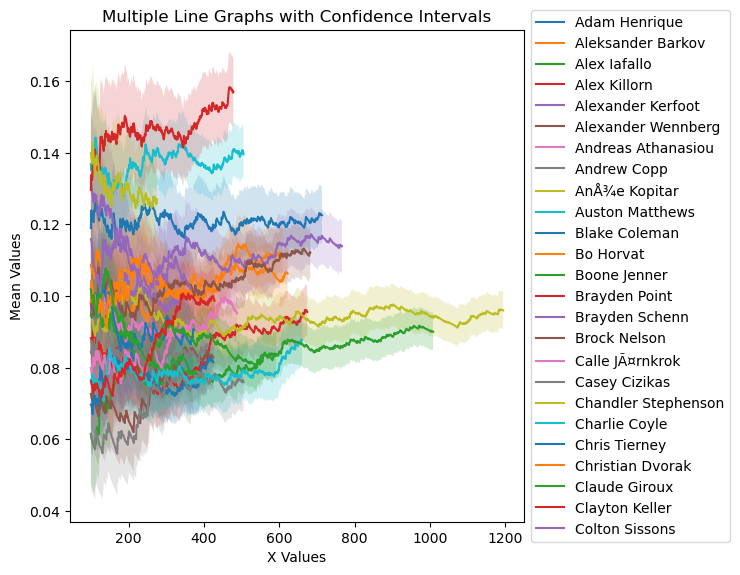

In [113]:
plot_multiple_with_confidence_intervals(mean_series=means, std_dev_series=stds, labels=labels, confidence=1)